# 1. Modeling of carbon cycle

In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in Tomizuka 2009.

In [1]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from matplotlib.ticker import MaxNLocator
import math
from scipy.integrate import odeint
from math import e


#### 1.1 [15 points] Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

In [2]:
df=pd.read_csv('global.1751_2008.ems.txt',sep='\s+',skiprows=27,    #Skip 27 lines
                  names=['year','total','gas','liquids','cement solids','gas production','per flaring','capita'])
df.head(5)

,year,total,gas,liquids,cement solids,gas production,per flaring,capita
0,1751,3,0,0,3,0,0,NaN
1,1752,3,0,0,3,0,0,NaN
2,1753,3,0,0,3,0,0,NaN
3,1754,3,0,0,3,0,0,NaN
4,1755,3,0,0,3,0,0,NaN


In [3]:
# The emission was observed to change rapidly over time and was simulated exponentially
def CO2_emis(t,r1,r2,r3): # Define the function that fits
    return np.exp(r1*t+r2)+r3
r1=0.1
r2=0.1
r3=0
p0=[r1,r2,r3] #Set the initial value of the fit
para,cov=optimize.curve_fit(CO2_emis,df['year'],df['total'],p0=p0)#Call the fitting function
emis_fit=[CO2_emis(a,*para) for a in df['year']] #Calculate the result after fitting
# print(para)
# plt.plot(df['year'],df['total']) 
# plt.plot(df['year'],emis_fit)
# plt.title('Global CO2 Emissions from Fossil-Fuel Burning,1751-2008() ')
# plt.show()                             # Comparison graph between true value and fitting
def model1(y,t,k12,k21,para):    #Define a function without the buffer effect
    N1,N2,r = y
    dydt=[-k12*N1+k21*N2+r,k12*N1-k21*N2,para[0]*(r-para[2])]
    return dydt

t=np.linspace(1987, 2004, 100)#independent variable
r=CO2_emis(t,*para)
k12=105/740
k21=102/900
N1=740*1000
N2=900*1000
y0=[N1,N2,r[0]] #initial value
sol = odeint(model1, y0, t, args=(k12,k21,para))/1000/740*347 #Call the carbon models function，the result is translated into ppm units
# plt.figure(figsize=(8,5))
# plt.plot(t, sol[:, 0], label='CO2 in atmosphere(ppm)')
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # Set the scale of the horizontal axis to an integer
# plt.legend(loc='best')
# plt.title('1987-2004 CO2 concentration without the buffer effect')
# plt.show()

#### 1.2 [20 points] Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

In [4]:
def model2(y,t,k12,k21,N0,para):    #Define a function with the buffer effect
    N1,N2,r2 = y
    bf=3.69+1.86e-2*(N1/740/1000*347)-1.8e-6*((N1/740/1000*347)**2) #buffer factor
    dydt=[-k12*N1+k21*(N0+bf*(N2-N0))+r2,    #  Due N0 is the equilibrium value of carbon in the surface ocean In the preindustrial era,                                             
          k12*N1-k21*(N0+bf*(N2-N0)),        # so the independent variables(t) should start in the preindustrial era
          para[0]*(r2-para[2])]
    return dydt
t2=np.linspace(1751, 2004, 253) #independent variable(start in the preindustrial era)
r2=CO2_emis(t2,*para)
k12=105/740
k21=102/900
N0=821*1000
N1=618*1000
N2=821*1000
y0=[N1,N2,r2[0]] #initial value
sol2 = odeint(model2, y0, t2, args=(k12,k21,N0,para))/740/1000*347 #Call the carbon models function，the result is translated into ppm units
# plt.figure(figsize=(8,5))
# plt.plot(t2[235:253],sol2[235:253,0], label='CO2 in atmosphere(ppm)')
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # Set the scale of the horizontal axis to an integer
# plt.legend(loc='best')
# plt.title('1987-2004 CO2 concentration with the buffer effect')
# plt.show()

#### 1.3 [5 points] Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

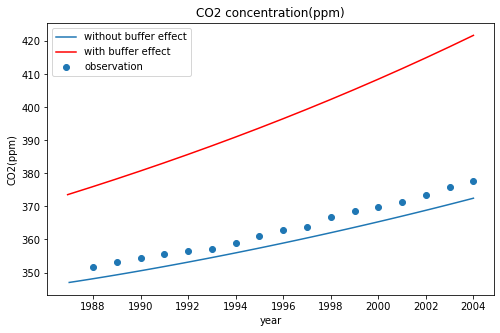

In [5]:
df2=pd.read_csv('co2_annmean_mlo.csv',sep=',',skiprows=57,usecols=[0,1], # obversed data
               names=['year','CO2'])
plt.figure(figsize=(8,5))
plt.plot(t, sol[:, 0]) # without buffer effect
plt.plot(t2[235:253], sol2[235:253,0], 'r') # with buffer effect
plt.scatter(df2['year'][28:45],df2['CO2'][28:45]) # observed data
plt.legend(['without buffer effect','with buffer effect','observation'],loc='best')
plt.xlabel('year')
plt.ylabel('CO2(ppm)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('CO2 concentration(ppm)')
plt.show()

#### [Bonus] [15 points] Following equation 5-13, compute the atmospheric CO2 level in ppm and reproduce Figure 4 in Tomizuka (2009).

In [6]:
def model3(N,t,rr,bf,f,da):  #defintion seveb-box model
    N02 = 821
    k12 = 60/615
    k21 = 60/842
    k23 = 9/842
    k24 = 43/842
    k32 = 52/9744
    k34 = 162/9744
    k43 = 205/26280
    k45 = 0.2/26280
    k51 = 0.2/90000000
    k67 = 62/731
    k71 = 62/1328
    N1,N2,N3,N4,N5,N6,N7 = N
    dN1dt = [-k12 * N1 + k21 * (N02 + bf*(N2 - N02)) + rr - f + da + k51 * N5 + k71 * N7,
            k12 * N1 - k21 * (N02 + bf*(N2 - N02)) - k23 * N2 + k32 * N3 - k24 * N2,
            k23*N2 - k32*N3 - k34*N3 +k43*N4,
            k34*N3 - k43*N4 + k24*N2 -k45*N4,
            k45*N4 - k51*N5,
            f - k67*N6 - 2*da,
            k67*N6 - k71*N7 + da]
    return dN1dt 
def buffer(CO2):   #defintion buffer
    bf = 3.69 + 1.86 * 10**-2 * CO2 - 1.80 * 10**-6 * CO2**2
    return bf 
def ff(P,beta):
    f0 = 62
    P0=290.21
    f = f0 * (1 + beta * math.log(P/P0))
    return f

In [9]:
# read the data 
rr = np.loadtxt("global.1751_2008.csv", delimiter=",", skiprows = 2, usecols = 1)/10**3
da = np.empty_like(rr)
da[0:100] = np.linspace(0.2,0.5,100)
da[99:-3]= np.loadtxt("Global_land-use_flux-1850_2005.csv", delimiter=",", skiprows = 1, usecols = 1)/10**3
da[-3:] = da[-4]
annualco2 = np.loadtxt("co2_annmean_mlo.csv", delimiter=",", skiprows = 56 )[:,1]
T = np.loadtxt("co2_annmean_mlo.csv", delimiter=",", skiprows = 56 )[:,0]
ynum = 2008 - 1751 + 1

t = np.linspace(1751,1751+ynum-1,ynum,dtype='int')
co2_obs = np.loadtxt("co2.csv", delimiter=",", skiprows = 149)
model3_b1 = np.empty_like(t)
model3_b2 = np.empty_like(t)
# situation of Bita=0.38    #reference shenshao
bb = 0.38
N0 = [615, 842, 9744, 26280, 90000000, 731, 1238]
model3_b1[0] = N0[0]
co2p = model3_b1[0]/2.13
bf = buffer(co2p)
f = ff(co2p,bb)
for i in range(1,ynum):# slove the ODE 
    dt = [0,1]    
    N = odeint(model3,N0,dt,args=(rr[i-1],bf,f,da[i-1])) # solve the equal
    model3_b1[i] = N[1][0]    # print the result
    co2p = model3_b1[i]/2.13 # initiation 
    N0 = N[1]
    bf = buffer(co2p)
    f = ff(co2p,bb)    
# situation of Bita=0.5
bb = 0.5
N0 = [615, 842, 9744, 26280, 90000000, 731, 1238]
model3_b2[0] = N0[0]
co2p = model3_b2[0]/2.13
bf = buffer(co2p)
f = ff(co2p,bb)
for i in range(1,ynum):
    dt = [0,1]    
    N = odeint(model3,N0,dt,args=(rr[i-1],bf,f,da[i-1])) # solve the equal
    model3_b2[i] = N[1][0]        # print the result
    co2p = model3_b2[i]/2.13   # initiation 
    N0 = N[1]

    bf = buffer(co2p)
    f = ff(co2p,bb)    

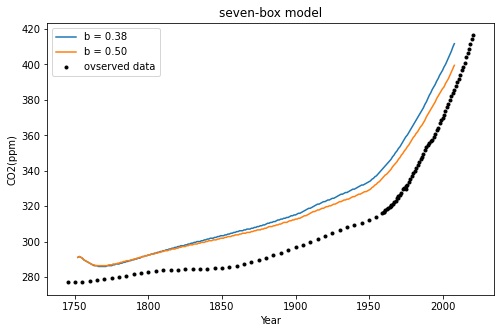

In [10]:
plt.figure(figsize=(8,5))
plt.plot(t[1:],model3_b1[1:]/2.13,label='b = 0.38') # plot Beta=0.38
plt.plot(t[1:],model3_b2[1:]/2.13,label='b = 0.50')  #plot Beta=0.5
plt.plot(co2_obs[:,0], co2_obs[:,1],'k.')
plt.plot(T,annualco2,'k.',label='ovserved data')   # ovserved data
plt.ylabel('CO2(ppm)')
plt.xlabel('Year')
plt.title('seven-box model')
plt.legend(loc='best')
plt.show()